In [1]:
import numpy as np
import tensorflow as tf
import os
import json
import glob
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.model_selection
import tensorflow_addons as tfa
from gensim.models import Word2Vec, FastText
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

__type = 'full'
# __type = 'pruned'

Num GPUs Available:  1


In [2]:
def read(path: str):
    balanced_labels = [
        'dp',
        'greedy',
        'implementation',
        'dfs and similar',
        'graphs',
        'brute force',
        'math',
        'number theory',
        'constructive algorithms',
        'trees',
        'binary search',
        'data structures',
        'two pointers',
        '*special',
        'sortings',
        'strings',
        'bitmasks',
        'combinatorics',
        'geometry',
    ]
    codes = []
    tags = []
    paths = []
    for i in tqdm.tqdm(glob.iglob(os.path.join(path, '*.json')), desc='Reading data', total=(len(os.listdir(path)) - 1) // 3):
        pre, ext = os.path.splitext(i)
        tags.append(list(filter(lambda tag: tag in balanced_labels, json.load(open(i, 'r', encoding='utf-8'))['Tags'])))
        statements = open(pre + '.java.ast.stm.flat', 'r', encoding='utf-8').read().strip('\n').split('\n\n')
        codes.append([])
        paths.append(i)
        for stm in statements:
            if len(stm) > 200:
                continue
            codes[-1].append([])
            for line in stm.split('\n'):
                try:
                    token, children = line.split('\t')
                    children = tuple(map(int, children.split())) if children else ()
                    codes[-1][-1].append((token, children))
                except Exception as e:
                    print(i)
                    print(line)
                    print()
                    print(stm)
                    raise e

    return codes, tags, paths

In [3]:
codes, tags, paths = read(f'../data/revisited/java/{__type}')

Reading data:   0%|          | 0/48537 [00:00<?, ?it/s]

In [4]:
for code, p in zip(codes, paths):
    for statement in code:
        for node, children in statement:
            for child in children:
                try:
                    _ = statement[child]
                except Exception as e:
                    print(p)
                    print(node)
                    print(child)
                    print(statement)
                    raise e

In [4]:
vocab = set()
for code in codes:
    for statement in code:
        for token, _ in statement:
            vocab.add(token)
vocab = list(vocab)
token_to_id = {j:i for i, j in enumerate(vocab)}
len(vocab)

46343

In [5]:
from collections import defaultdict

freq = defaultdict(int)
labels = set()
for tag_list in tags:
    for tag in tag_list:
        labels.add(tag)
        freq[tag] += 1
labels = list(labels)
label_to_id = {label: i for i, label in enumerate(labels)}

len(labels), freq

(19,
 defaultdict(int,
             {'dp': 8642,
              'greedy': 13835,
              'implementation': 20837,
              'dfs and similar': 3067,
              'graphs': 2986,
              'brute force': 7896,
              'math': 14851,
              'number theory': 5538,
              'constructive algorithms': 11079,
              'trees': 1945,
              'binary search': 2635,
              'data structures': 4172,
              'two pointers': 1612,
              '*special': 1852,
              'sortings': 4213,
              'strings': 4391,
              'bitmasks': 1299,
              'combinatorics': 1274,
              'geometry': 1237}))

In [6]:
vector_size = 192

In [12]:
w2v_model = Word2Vec.load(f'../embeddings/revisited/java/{__type}/stm.w2v')
w2v_wv = w2v_model.wv
w2v_embeddings = np.array([w2v_wv[i] if i in w2v_wv else np.zeros((vector_size,)) for i in vocab])

In [7]:
ft_model = FastText.load(f'../embeddings/revisited/java/{__type}/stm.ft')
ft_wv = ft_model.wv
ft_embeddings = np.array([ft_wv[i] if i in ft_wv else np.zeros((vector_size,)) for i in vocab])

In [13]:
print(w2v_embeddings[0][:10])
print(ft_embeddings[0][:10])
print(sum(i in w2v_wv for i in vocab), len(vocab))
print(sum(i in ft_wv for i in vocab), len(vocab))
print(len(w2v_model.wv.key_to_index))
print(len(ft_model.wv.key_to_index))

[-0.00996109  0.01853905  0.04357075 -0.06149104  0.04350245  0.0757494
  0.10162805 -0.05165766  0.02721444 -0.12090312]
[-16.046976   -1.534591   20.914219    8.221931    1.2179637 -15.312166
 -40.591694   23.785963  -38.204758  -37.188934 ]
46343 46343
46343 46343
54385
54385


In [8]:
vectorized = []
indices = []
he_tags = []

statements_hist = []
nodes_hist = []
max_code_len = -1
max_statement_len = -1

for code in codes:
    vectorized.append([])
    indices.append([])
    max_code_len = max(max_code_len, len(code))
    statements_hist.append(len(code))
    for statement in code:
        vectorized[-1].append([])
        indices[-1].append([])
        max_statement_len = max(max_statement_len, len(statement))
        nodes_hist.append(len(statement))
        for token, _ in statement:
            vectorized[-1][-1].append(token_to_id[token] + 1)
            indices[-1][-1].append(_)

for tag_list in tags:
    he_tags.append([0] * len(labels))
    for tag in tag_list:
        he_tags[-1][label_to_id[tag]] = 1

In [9]:
print(vectorized[0])
print(indices[0])
print(he_tags[:3])

[[42904, 37495, 39348, 31392], [17598, 37495, 39348, 39579, 31813, 39348, 15407, 369, 39348, 27426, 38499], [20827, 27039, 39348, 31504, 26696, 39348, 28003], [20153, 13402, 7760, 39348, 13578], [20827, 27039, 39348, 31504, 26696, 39348, 43119, 32881, 19995, 23058], [16983, 6594, 27508, 12262, 17431, 45960, 39348, 28003, 32881, 19995, 23058, 6957], [24890, 6594, 27508, 12262, 34159, 45960, 39348, 28003, 6957, 6957], [20153, 13402, 20363, 39348, 34040, 6506, 32881, 19995, 23058], [40782, 13707, 12262, 17876, 45960, 39348, 28003], [20153, 13402, 20363, 39348, 34040, 6506, 32881, 19995, 23058], [40782, 45960, 39348, 43119, 41822, 30129, 12262, 33392], [20153, 13402, 20363, 39348, 31533, 6506, 32881, 19995, 23058], [20153, 13402, 43739, 39348, 11792, 6506, 45960, 39348, 43119]]
[[(1,), (2,), (3,), ()], [(1, 10), (2, 4), (3,), (), (5, 7), (6,), (), (8,), (9,), (), ()], [(1, 4), (2,), (3,), (), (5,), (6,), ()], [(1, 3), (2,), (), (4,), ()], [(1, 4), (2,), (3,), (), (5, 7), (6,), (), (8,), (9

56.84589076374724
999


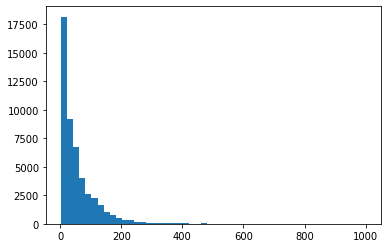

In [16]:
plt.hist(statements_hist, bins=50)
print(np.mean(statements_hist))
print(max_code_len)

8.168803995753732
20


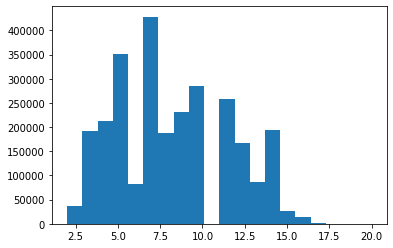

In [17]:
plt.hist(nodes_hist, bins=20)
print(np.mean(nodes_hist))
print(max_statement_len)

In [10]:
def get_embedding(shape: tuple, vocab: list, input_size: int, output_size: int, shift: int = 0, pre_trained = None):
    embedding = tf.keras.layers.Embedding(input_size, output_size, name='Tree_Embedding', mask_zero=True)
    embedding.build(shape)
    embedding.trainable = pre_trained is None
    if pre_trained is not None:
        weights = np.zeros((input_size, output_size))
        for i, token in enumerate(vocab):
            try:
                weights[i + shift] = pre_trained[i]
            except:
                pass
        embedding.set_weights([weights])
    return embedding


def get_embedding_encoder(input_shape: tuple, output_size: int):
    inputs = tf.keras.layers.Input(input_shape)
    outputs = tf.keras.layers.Dense(output_size)(inputs)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='Embedding_Encoder')


def get_statement_encoder(input_shape: tuple, filters: int):
    inputs = tf.keras.layers.Input(input_shape)
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size=3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Lambda(lambda tensor: tf.math.reduce_max(tensor, axis=2))(x)
    return tf.keras.Model(inputs=inputs, outputs=x, name='Statement_Encoder')


def get_tree_encoder(input_shape: tuple, predict: bool = False, backbone: str = 'rnn'):
    inputs = tf.keras.layers.Input(input_shape, name='Inputs')
    dropout = tf.keras.layers.Dropout(0.1, name='Embedding_Dropout')(inputs)
    if backbone == 'rnn':
        x = tf.keras.layers.Bidirectional(
                tf.keras.layers.RNN(tf.keras.layers.GRUCell(units=128)),
            name='Double_Bidirectional_GRU')(dropout)
    else:
        n_layers = 2
        kernels = [3, 5, 7]
        layers = []
        for k in kernels:
            x = dropout
            n = x.shape[-1]
            for i in range(n_layers):
                x = tf.keras.layers.Conv1D(n, k, activation=tf.keras.activations.swish, padding='same', name=f'Conv1D_{k}_{n}')(x)
                x = tf.keras.layers.BatchNormalization(name=f'Batch_Norm_{k}_{n}')(x)
                n *= 2
            x = tf.keras.layers.GlobalMaxPooling1D(name=f'Max_Pool_{k}')(x)
            layers.append(x)
        x = tf.keras.layers.Concatenate(axis=-1, name='Pool_Concatenate')(layers)
        x = tf.keras.layers.Dropout(0.2, name='Concatenate_Dropout')(x)
    if predict:
        x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x, name='Tree_Encoder')

In [11]:
class StatementDataset(tf.keras.utils.Sequence):
    def __init__(self, vectorized, indices, he_tags, batch_size):
        self.vectorized = vectorized
        self.indices = indices
        self.he_tags = he_tags
        self.batch_size = batch_size
        self.shuffle()

    def __len__(self):
        return (len(self.vectorized) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        vectorized_batch = vectorized[start:end]
        indices_batch = indices[start:end]
        he_tags_batch = he_tags[start:end]

        max_len = max(len(j) for i in vectorized_batch for j in i)
        code_batch = tf.keras.preprocessing.sequence.pad_sequences(
            [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
            padding='post'
        )
        code_batch = code_batch[:,1:129]
        indices_batch = [[i[j] for j in range(1, min(129, len(i)))] for i in indices_batch]
        return (code_batch, indices_batch), he_tags_batch

    def shuffle(self):
        indices = np.arange(len(self.vectorized))
        np.random.shuffle(indices)

        self.vectorized = [self.vectorized[i] for i in indices]
        self.indices = [self.indices[i] for i in indices]
        self.he_tags = [self.he_tags[i] for i in indices]

    def on_epoch_end(self):
        self.shuffle()

In [12]:
shift = 1
emb_input_size = len(vocab) + shift
emb_output_size = 192
emb_encoder_output_size = 128
backbone = 'cnn'
path = f'java_statements_model_revisited/{backbone}'

def calc_logits(code_batch, indices_batch, embedding, embedding_encoder_model, tree_encoder_model):
    # b: code_batch length
    # n: code_batch.shape[1] -- number of sequences in code
    # m: code_batch.shape[2] -- number of statements in sequence
    # e: embedding vector size
    # code_batch: (b, n, m,)
    # encoded: (b, n, m, e,)
    encoded = embedding_encoder_model(embedding(code_batch), training=True)
    encoded_as_list = [[[encoded[i, j, k] for k in range(code_batch.shape[2])] for j in range(code_batch.shape[1])] for i in range(len(code_batch))]
    # statement encoding over known embeddings
    for i in range(len(indices_batch)):
        for j in range(len(indices_batch[i])):
            for k in range(len(indices_batch[i][j]) - 1, -1, -1):
                children = indices_batch[i][j][k]
                if not children:
                    continue
                encoded_as_list[i][j][k] = tf.reduce_sum([
                    encoded_as_list[i][j][k],
                    *(encoded_as_list[i][j][l] for l in children)
                ], axis=0)
    pooled = tf.math.reduce_max(encoded_as_list, axis=2)
    logits = tree_encoder_model(pooled, training=True)
    return logits


def calc_loss(y_true, y_pred, metrics=None):
    metrics = metrics or []
    loss = tf.math.reduce_mean(tf.keras.losses.binary_crossentropy(y_true, y_pred))
    for metric in metrics:
        metric.update_state(y_true, y_pred)
    return loss


def tree_encoding_step(optimizer, code_batch, indices_batch, he_tags_batch, metrics):
    with tf.GradientTape() as tape:
        logits = calc_logits(code_batch, indices_batch,
                             embedding, embedding_encoder_model, tree_encoder_model)
        loss = calc_loss(he_tags_batch, logits, metrics)
        trainable_weights = tree_encoder_model.trainable_weights + embedding_encoder_model.trainable_weights
    grads = tape.gradient(loss, trainable_weights)
    optimizer.apply_gradients(zip(grads, trainable_weights))
    return loss


def models_parallel_train(epochs: int, batch_size: int):
    # split data
    vectorized_train, vectorized_test, \
    indices_train, indices_test, \
    he_tags_train, he_tags_test = \
        sklearn.model_selection.train_test_split(vectorized,
                                                 indices,
                                                 he_tags)

    # create datasets
    train_dataset = StatementDataset(vectorized_train, indices_train, he_tags_train, batch_size=batch_size)
    test_dataset = StatementDataset(vectorized_test, indices_test, he_tags_test, batch_size=batch_size)

    # create handlers for logging
    os.makedirs(path, exist_ok=True)
    train_loss_log = open(os.path.join(path, 'train_loss.txt'), 'w', encoding='utf-8')
    train_f1_log   = open(os.path.join(path, 'train_f1.txt'),   'w', encoding='utf-8')
    test_loss_log  = open(os.path.join(path, 'test_loss.txt'),  'w', encoding='utf-8')
    test_f1_log    = open(os.path.join(path, 'test_f1.txt'),    'w', encoding='utf-8')

    try:
        optimizer = tf.keras.optimizers.Adamax(learning_rate=2e-3)
        metrics = [tfa.metrics.F1Score(len(labels), average='macro')]
        for epoch in tqdm.trange(epochs):

            #train
            loss = 0
            pbar = tqdm.tqdm(enumerate(train_dataset), total=len(train_dataset))
            for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
                loss_value = tree_encoding_step(optimizer,
                                                code_batch,
                                                indices_batch,
                                                he_tags_batch,
                                                metrics)
                loss += loss_value.numpy()
                mean_loss = f'{loss / (step + 1):.3f}'
                f1_score = f'{metrics[0].result().numpy():.3f}'
                pbar.set_description(f'[TRAIN] | Loss: {mean_loss}; F1: {f1_score}')
                if step % 100 == 0:
                    train_loss_log.write(f'{mean_loss} ')
                    train_f1_log.write(f'{f1_score} ')
            train_loss_log.write('\n')
            train_f1_log.write('\n')

            # save
            embedding_encoder_model.save(os.path.join(path, f'embedding_encoder_weights_{total_epochs + epoch}'))
            tree_encoder_model.save(os.path.join(path, f'statement_tree_encoder_weights_{total_epochs + epoch}'))

            # reset metrics
            for metric in metrics:
                metric.reset_state()

            # test
            loss = 0
            pbar = tqdm.tqdm(enumerate(test_dataset), total=len(test_dataset))
            for step, ((code_batch, indices_batch), he_tags_batch) in pbar:
                logits = calc_logits(code_batch, indices_batch,
                                     embedding, embedding_encoder_model, tree_encoder_model)
                loss_value = calc_loss(he_tags_batch, logits, metrics)
                loss += loss_value.numpy()
                mean_loss = f'{loss / (step + 1):.3f}'
                f1_score = f'{metrics[0].result().numpy():.3f}'
                pbar.set_description(f'[TEST] | Loss: {mean_loss}; F1: {f1_score}')

            test_loss_log.write(f'{loss / len(test_dataset)}\n')
            test_f1_log.write(f'{metrics[0].result().numpy():.3f}\n')

            # reset metrics
            for metric in metrics:
                metric.reset_state()

            train_loss_log.flush()
            train_f1_log.flush()
            test_loss_log.flush()
            test_f1_log.flush()
            train_dataset.on_epoch_end()
    finally:
        train_loss_log.close()
        train_f1_log.close()
        test_loss_log.close()
        test_f1_log.close()


embedding = get_embedding(shape=(None, None, None),
                          input_size=emb_input_size,
                          output_size=emb_output_size,
                          pre_trained=ft_embeddings,
                          shift=1,
                          vocab=vocab)
embedding_encoder_model = get_embedding_encoder(input_shape=(None, None, emb_output_size),
                                                output_size=emb_encoder_output_size)
tree_encoder_model = get_tree_encoder(input_shape=(None, emb_encoder_output_size),
                                      predict=True, backbone=backbone)

total_epochs = 0

In [69]:
# total_epochs = 4
# embedding_encoder_model = tf.keras.models.load_model(f'{path}/embedding_encoder_weights_{total_epochs - 1}')
# tree_encoder_model = tf.keras.models.load_model(f'{path}/statement_tree_encoder_weights_{total_epochs - 1}')

In [ ]:
models_parallel_train(epochs=5, batch_size=4)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9101 [00:00<?, ?it/s]

INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\embedding_encoder_weights_0\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_0\assets


INFO:tensorflow:Assets written to: java_statements_model_revisited/cnn\statement_tree_encoder_weights_0\assets
d:\git\yepcode\venv\lib\site-packages\tensorflow\python\keras\metrics.py:254: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  warnings.warn('Metric %s implements a `reset_states()` method; rename it '


  0%|          | 0/3034 [00:00<?, ?it/s]

  0%|          | 0/9101 [00:00<?, ?it/s]

In [ ]:
# def get_combined_model(input_shape: tuple, embedding, encoder, statement_encoder, tree_encoder):
#     inputs = tf.keras.layers.Input(input_shape, name='Statement_Trees')
#     x = embedding(inputs)
#     x = encoder(x)
#     x = statement_encoder(x)
#     x = tree_encoder(x)
#     x = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.swish, name='Dense')(x)
#     x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
#     model = tf.keras.models.Model(inputs=inputs, outputs=x, name='PSLNN_Combined')
#     model.summary()
#     model.compile(optimizer='adam', loss='binary_crossentropy')
#     return model

# def statement_encoding(epochs: int, batch_size: int):
#     loss_fn = tf.keras.losses.CategoricalCrossentropy()
#     optimizer = tf.keras.optimizers.Adam()
#
#     for epoch in tqdm.trange(epochs):
#         vectorized_batches = batch(vectorized, batch_size)
#         indices_batches = batch(indices, batch_size)
#         he_tags_batches = batch(he_tags, batch_size)
#         pbar = tqdm.tqdm(enumerate(zip(vectorized_batches, indices_batches, he_tags_batches)), total=len(vectorized) // batch_size)
#         for step, (vectorized_batch, indices_batch, he_tags_batch) in pbar:
#             max_len = max(len(j) for i in vectorized_batch for j in i)
#             code_batch = tf.keras.preprocessing.sequence.pad_sequences(
#                 [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
#                 padding='post'
#             )
#             with tf.GradientTape() as tape:
#                 # m: max_len
#                 # code_batch: b x n x m
#                 # encoded: b x n x m x e
#                 encoded = encoder_model(embedding(code_batch), training=True)
#                 pooled = statement_encoder_model(encoded, training=True)
#                 #logits = model(pooled, training=True)
#                 #loss_value = loss_fn(he_tags_batch, logits)
#
#             #grads = tape.gradient(loss_value, model.trainable_weights + encoder_model.trainable_weights)
#             #optimizer.apply_gradients(zip(grads, model.trainable_weights + encoder_model.trainable_weights))
#             #pbar.set_description(str(loss_value.numpy()))

In [ ]:
# class FlatteningDataset(tf.keras.utils.Sequence):
#     def __init__(self, vectorized, indices, he_tags, batch_size):
#         self.vectorized = vectorized
#         self.indices = indices
#         self.he_tags = he_tags
#         self.batch_size = batch_size
#
#     def __len__(self):
#         return (len(self.vectorized) + self.batch_size - 1) // self.batch_size
#
#     def __getitem__(self, idx):
#         start = idx * self.batch_size
#         end = (idx + 1) * self.batch_size
#         vectorized_batch = vectorized[start:end]
#         indices_batch = indices[start:end]
#         he_tags_batch = he_tags[start:end]
#
#         vectorized_batch = [[st for sequence in code for st in sequence] for code in vectorized_batch]
#         code_batch = tf.keras.preprocessing.sequence.pad_sequences(vectorized_batch, maxlen=1024, padding='post')
#         return code_batch, np.array(he_tags_batch)
#
#     def on_epoch_end(self):
#         pass

# shift = 1
# emb_input_size = len(vocab) + shift
# emb_output_size = 192
#
# flat_model = get_flat_model(input_shape=(None,),
#                             embedding=get_embedding(shape=(None, None),
#                                                     vocab=vocab,
#                                                     input_size=emb_input_size,
#                                                     output_size=emb_output_size,
#                                                     shift=shift,
#                                                     pre_trained=ft_embeddings))
#
# flat_dataset = FlatteningDataset(vectorized, indices, he_tags, batch_size=8)
#
# emb_encoder_output_size = 128